In [1]:
# Manipulation des fichiers
import os
from pathlib import Path

# manipulation des données tabulaires
import pandas as pd
import numpy as np

# Manipulation des images
import cv2

# Visualisation de données
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
%matplotlib inline
from tqdm.notebook  import tqdm

## Explicabilité des modèles
from lime import lime_image
from skimage import segmentation

# Fonctions de chargement des données
import FETCH_LOAD_DATAS_p6

In [2]:
# paramètres d'affichage général

pd.set_option('display.max_rows', 120)


import warnings
warnings.filterwarnings("ignore")

In [3]:
# contrôle de la reproductibilité des résultats aléatoires

SEED = 49

In [4]:
# fonction de sauvegarde des illustrations

IMAGES_PATH = Path() / "img_results"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

ID_FIG = 0

def save_fig(fig_title, resolution=300):
    fig_id = str(globals()['ID_FIG'])
    path = IMAGES_PATH / f"{fig_id} - {fig_title}.png"
    globals()['ID_FIG']+=1
    plt.savefig(path, format='png', dpi=resolution)

In [5]:
# fonctions de sauvegarde et chargement des résultats

INTER_RESULTS_PATH = Path() / "results"
INTER_RESULTS_PATH.mkdir(parents=True, exist_ok=True)

def save_pickle(results, file_name):
    file_path = INTER_RESULTS_PATH / f"{file_name}.pkl"
    filehandler = open(file_path,"wb")
    pickle.dump(results, filehandler)
    filehandler.close()
    print(f"Fichier enregistré sous le nom '{file_name}' ")

def load_pickle(file_name):
    file_path = INTER_RESULTS_PATH / f"{file_name}.pkl"
    file = open(file_path,'rb')
    globals()[file_name] = pickle.load(file)
    file.close()
    print(f"Variable créée sous le nom '{file_name}' ")

# Exploration du jeu de données

## Informations générales sur le jeu

In [6]:
# cellule à n'exécuter qu'une seule fois au démarrage du projet pour télécharger les images (nécessite une connexion internet)
# FETCH_LOAD_DATAS_p6.fetch_dogs_data()

In [7]:
df_breed = FETCH_LOAD_DATAS_p6.load_dogs_data()

In [8]:
df_breed

file_name                                          file_path  \
0   n02085620_10074.jpg  datas/Images\n02085620-Chihuahua\n02085620_100...   
0   n02085620_10131.jpg  datas/Images\n02085620-Chihuahua\n02085620_101...   
0   n02085620_10621.jpg  datas/Images\n02085620-Chihuahua\n02085620_106...   
0    n02085620_1073.jpg  datas/Images\n02085620-Chihuahua\n02085620_107...   
0   n02085620_10976.jpg  datas/Images\n02085620-Chihuahua\n02085620_109...   
..                  ...                                                ...   
0    n02116738_9798.jpg  datas/Images\n02116738-African_hunting_dog\n02...   
0    n02116738_9818.jpg  datas/Images\n02116738-African_hunting_dog\n02...   
0    n02116738_9829.jpg  datas/Images\n02116738-African_hunting_dog\n02...   
0    n02116738_9844.jpg  datas/Images\n02116738-African_hunting_dog\n02...   
0    n02116738_9924.jpg  datas/Images\n02116738-African_hunting_dog\n02...   

                  breed  
0             Chihuahua  
0             Chihuahua  
0             Chihuahua  
0             Chihuahua  
0             Chihuahua  
..                  ...  
0   African_hunting_dog  
0   African_hunting_dog  
0   African_hunting_dog  
0   African_hunting_dog  
0   African_hunting_dog  

[20580 rows x 3 columns]

In [9]:
df_breed['breed'].value_counts()

Maltese_dog                       252
Afghan_hound                      239
Scottish_deerhound                232
Pomeranian                        219
Bernese_mountain_dog              218
Samoyed                           218
Irish_wolfhound                   218
Shih                              214
Great_Pyrenees                    213
Leonberg                          210
basenji                           209
Tibetan_terrier                   206
Sealyham_terrier                  202
EntleBucher                       202
Airedale                          202
pug                               200
Saluki                            200
cairn                             197
Lakeland_terrier                  197
Australian_terrier                196
papillon                          196
chow                              196
Norwegian_elkhound                196
beagle                            195
Newfoundland                      195
Siberian_husky                    192
Ibizan_hound

In [10]:
df_breed['breed'].value_counts().mean()

171.5

In [11]:
df_breed['breed'].value_counts().min()

148

In [12]:
df_breed['breed'].value_counts().max()

252

<Axes: ylabel='Count'>

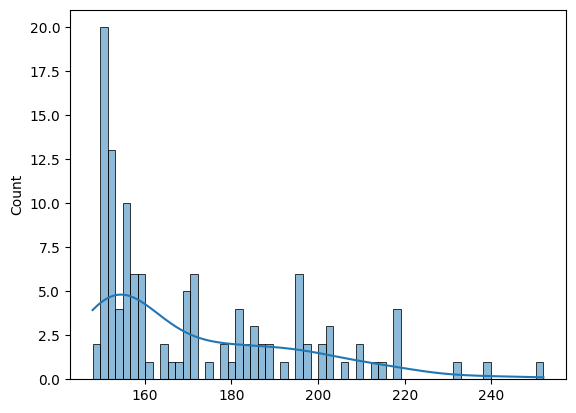

In [13]:
sns.histplot(df_breed['breed'].value_counts().values, bins=60, kde=True)

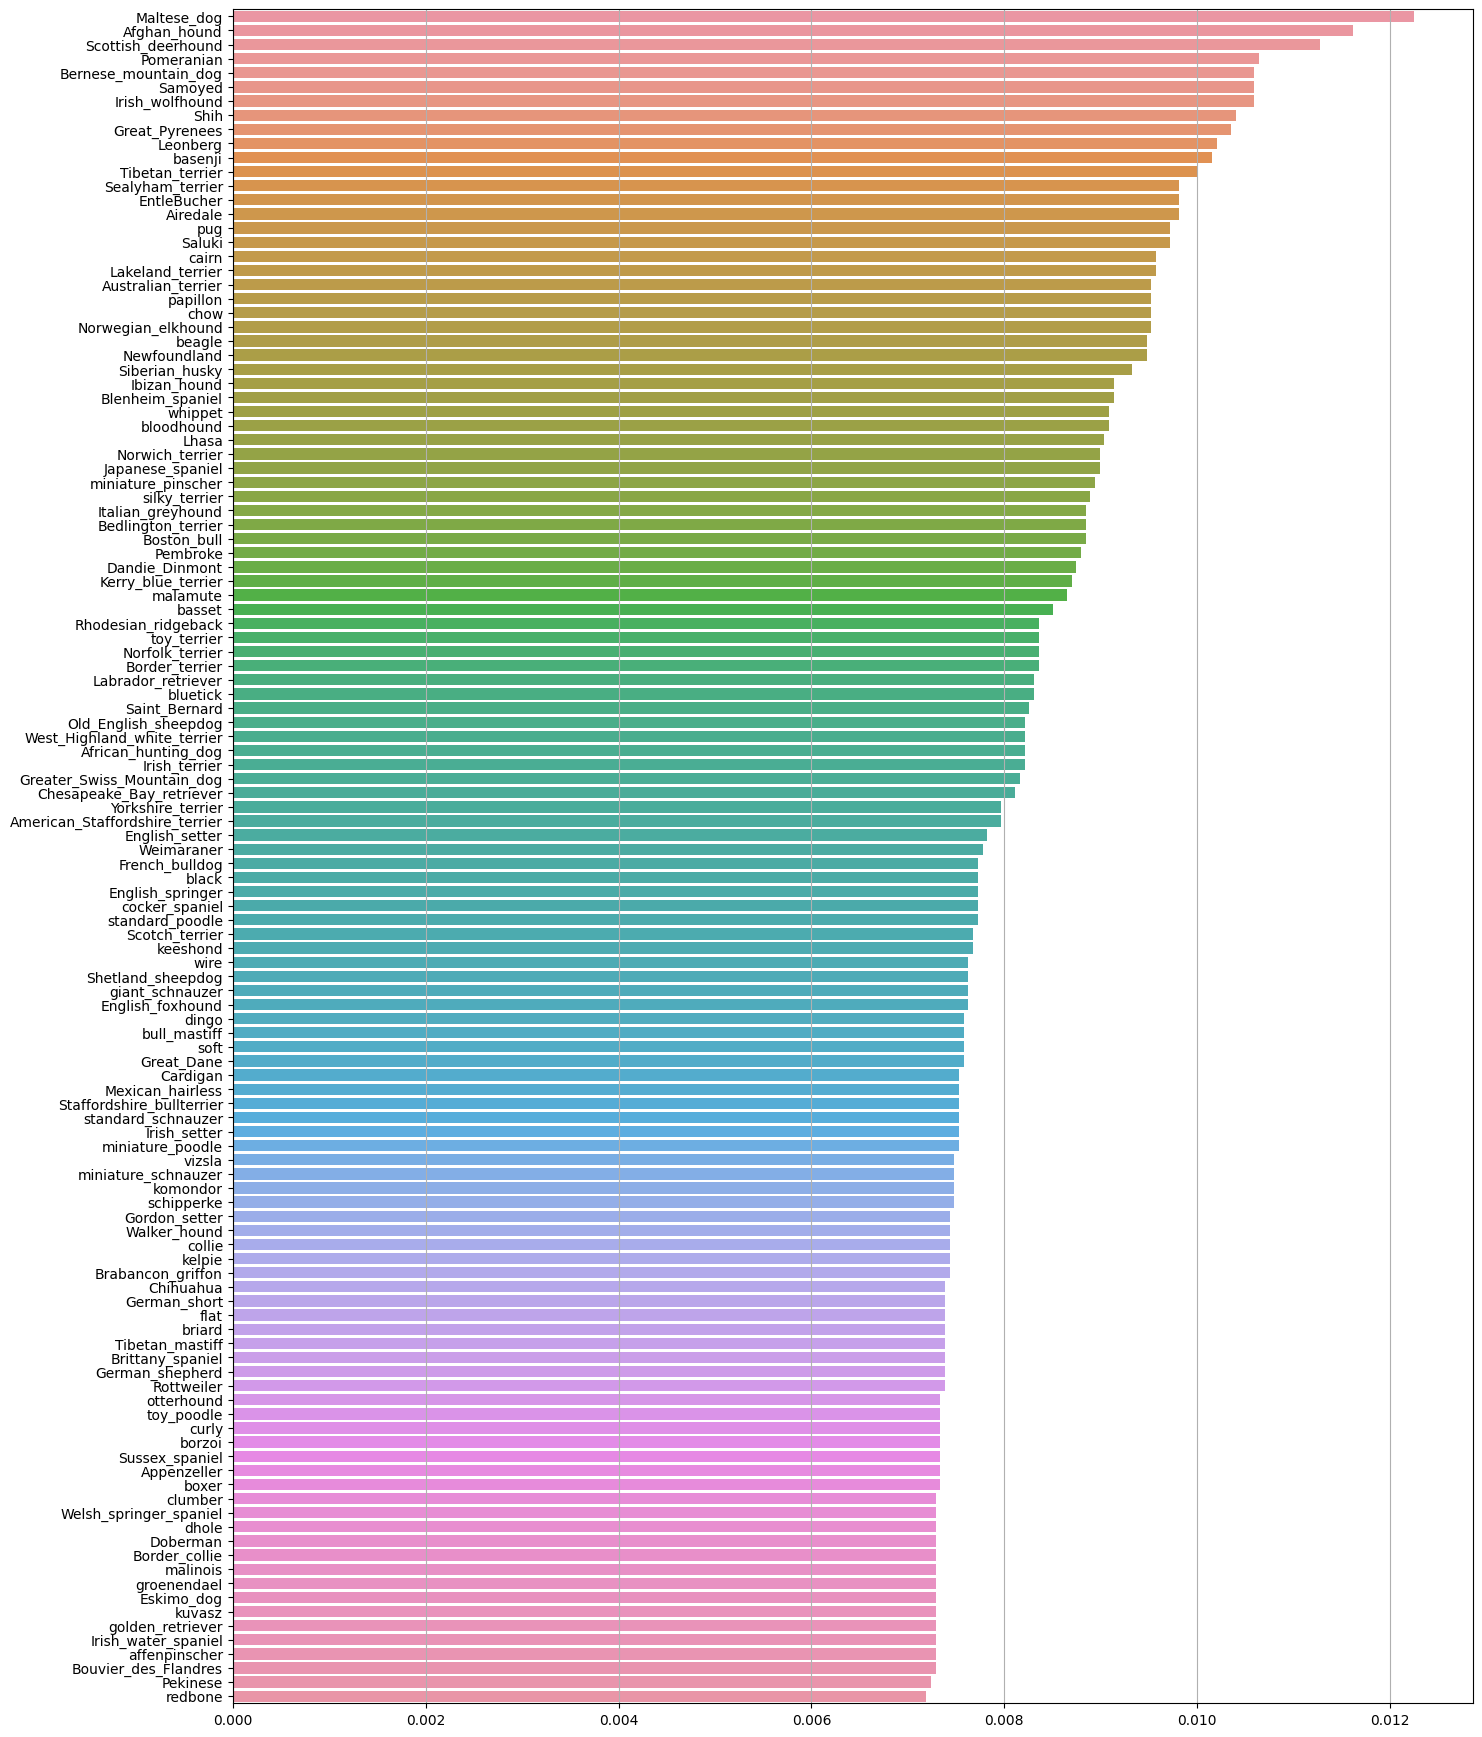

In [14]:
plt.figure(figsize=(16,22))
sns.barplot(x=df_breed['breed'].value_counts(normalize=True).values, y=df_breed['breed'].value_counts(normalize=True).index)
plt.grid(axis='x')

## Exploration des images

Nous allons définir 2 fonctions utiles pour la suite de notre travail :

   1. la première pour charger une image avec la librairie *OpenCV* depuis un fichier
   2. la seconde pour afficher une ou plusieurs images à la fois

In [15]:
def load_img(file, ext=['.png','.jpg','.jpeg','.JPG']):
    """
        Objectif : 
            charger une image avec la librairie OpenCV depuis un fichier image en local
        
        Arguments:
            file : chemin d'accès au fichier image à charger
            ext : liste des extensions de fichiers supportées
        
        Valeur retournée:
            img : objet image affichable
    """
    
    if file.endswith(tuple(ext)):
        img = cv2.imread(file, cv2.IMREAD_UNCHANGED)
        if len(img.shape) > 2:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        return img
    else:
        print("file extension unknown")

In [35]:
def plot_imgs(imgs, titles=[]):
    """
        Objectif : 
            Afficher une ou plusieurs images à la fois
        
        Arguments:
            imgs : liste d'objets image
            titles : liste des titres associés aux objets image
        
        Valeur retournée:
            None : affiche la ou les images
    """
        
    if (len(imgs) == 1) or (type(imgs) not in [list,pd.core.series.Series]):
        img = imgs if type(imgs) is not list else imgs[0]
        title = None if len(titles) == 0 else (titles[0] if type(titles) is list else titles)
        plt.figure(figsize=(5,3))
        plt.suptitle(title, fontsize=15)
        if len(img.shape) > 2:
            plt.imshow(img)
        else:
            plt.imshow(img, cmap=plt.cm.binary)

    else:
        nrows = len(imgs)//5 if len(imgs)%5 == 0 else len(imgs)//5 + 1
        nb_cols_last_rows = len(imgs)%5
        
        titles = None if len(titles) == 0 else (titles[0] if type(titles) is list and len(titles)==1 else titles)
        
        for i in range(nrows):
            if i != (nrows-1):
                fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(25,5))
            else:
                fig, axes = plt.subplots(nrows=1, ncols=nb_cols_last_rows, figsize=(5*nb_cols_last_rows,5))
            
            for j, img in enumerate(imgs[5*i:5*(i+1)]):
                ax = axes[j] if type(axes) == np.ndarray else axes
                if len(img.shape) > 2:
                    ax.imshow(img)
                else:
                    ax.imshow(img, cmap=plt.cm.binary)

                ax.set_title(titles[5*i+j])
            
    plt.tight_layout()
    plt.show()

In [36]:
img = load_img(df_breed['file_path'].sample(1)[0])

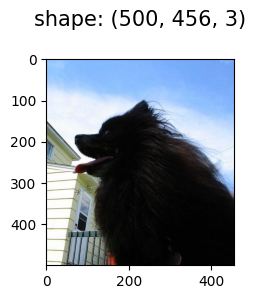

In [37]:
plot_imgs(img, "shape: "+str(img.shape))

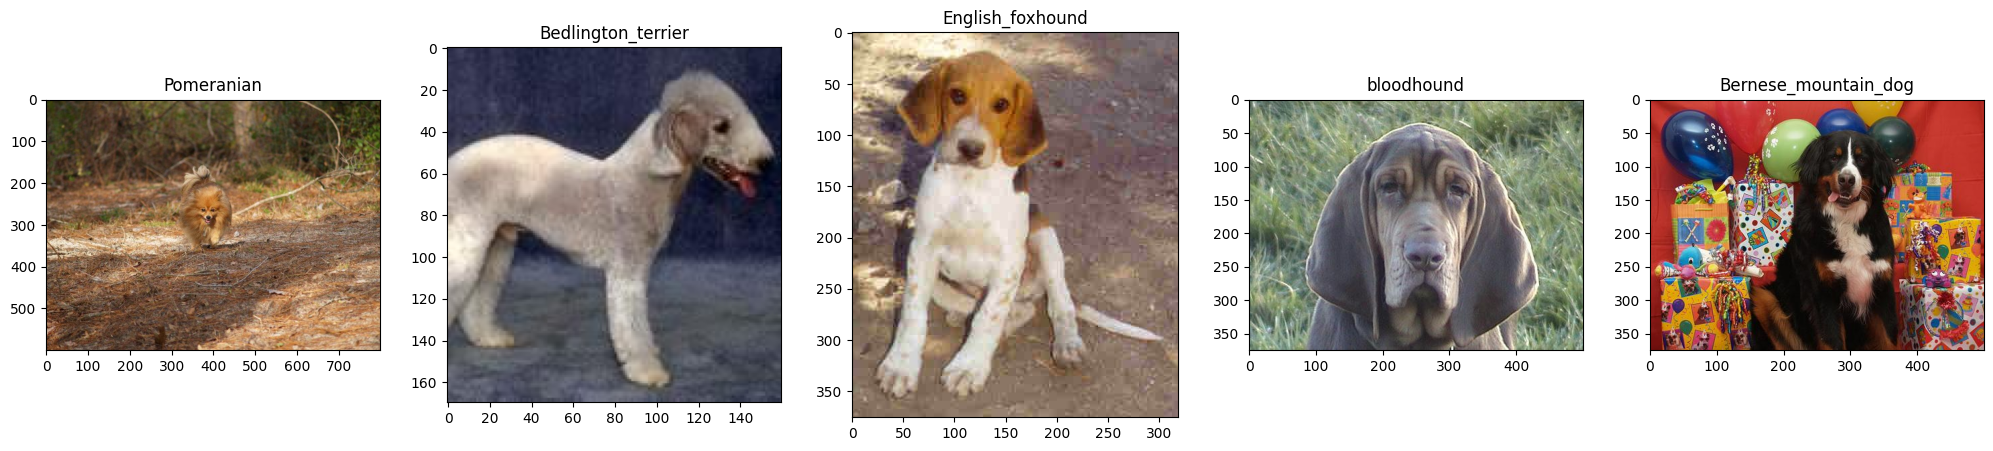

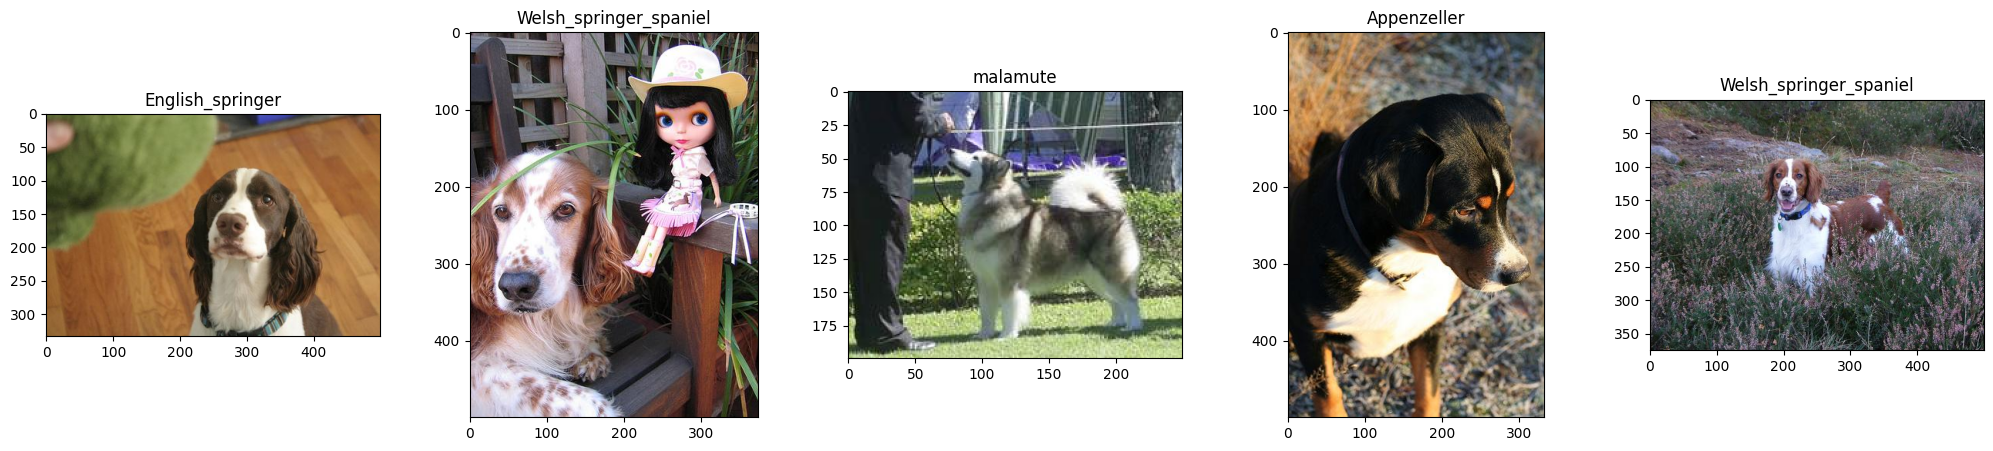

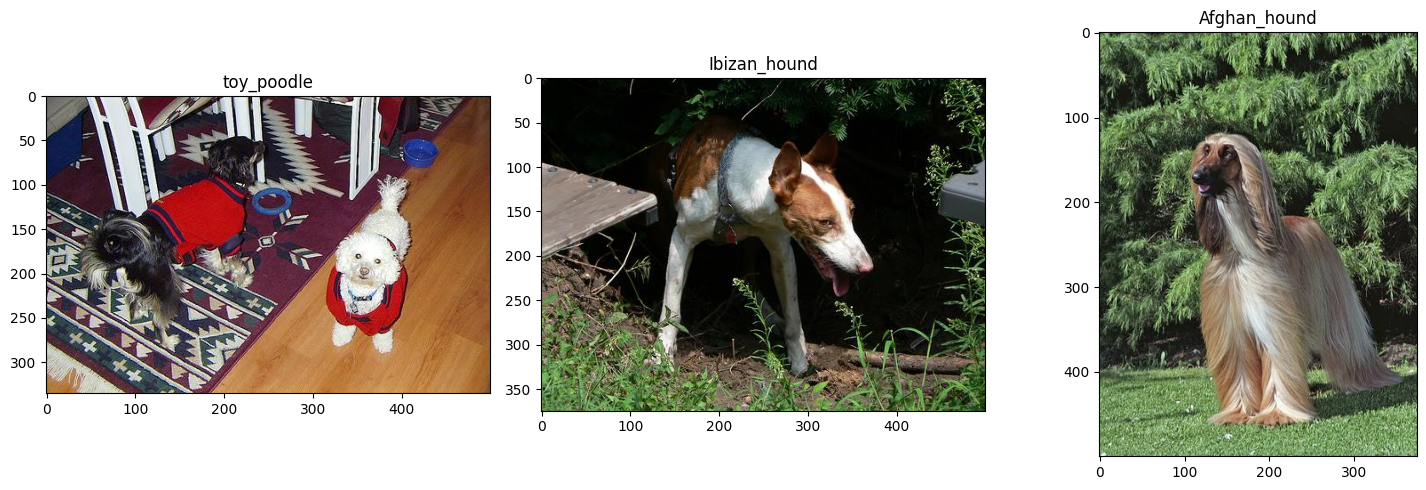

In [40]:
samples = df_breed.sample(13)
imgs = [load_img(img_path) for img_path in samples['file_path'].values]
# plot_imgs(imgs, titles=["shape: "+str(img.shape) for img in imgs])
plot_imgs(imgs, titles=samples['breed'].values)